In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions
using LinearAlgebra
using Test

using ForwardDiff
# using ReverseDiff
# using FiniteDifferences

using Revise
using EuclidianNormalizingFlows

┌ Info: Precompiling EuclidianNormalizingFlows [eb90128f-7c94-4cd6-9130-4bb7c9abac9d]
└ @ Base loading.jl:1423


In [4]:
# Compare transformation results & gradients using Finite Differences and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 20,
        ndims = 10,
        nparams = 10,
        nsmpls = 30,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions

        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 5), ndims, nsmpls)
        
        try 
            
            trafo_frwd = RationalQuadSpline(w,h,d)
            trafo_bcwd = RationalQuadSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            for j in 1:size(x, 2)
                xrun = x[:,j]
                
#                 autodiff_jac = FiniteDifferences.jacobian(algo, xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )[1]
                autodiff_jac = ForwardDiff.jacobian(xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )
                @test log(abs(det(autodiff_jac))) ≈ jac_frwd[1,j]
                @test log(abs(det(autodiff_jac))) ≈ -jac_bcwd[1, j]
            end

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)
            @test a_run ≈ gradvals.widths

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)
            @test a_run ≈ gradvals.heights

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)
            @test a_run ≈ gradvals.derivatives
            
            println("Test no. $i successfull!")
        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

Test no. 1 successfull!
Test no. 2 successfull!
Test no. 3 successfull!
Test no. 4 successfull!
Test no. 5 successfull!
Test no. 6 successfull!
Test no. 7 successfull!
Test no. 8 successfull!
Test no. 9 successfull!
Test no. 10 successfull!
Test no. 11 successfull!
Test no. 12 successfull!
Test no. 13 successfull!
Test no. 14 successfull!
Test no. 15 successfull!
Test no. 16 successfull!
Test no. 17 successfull!
Test no. 18 successfull!
Test no. 19 successfull!
Test no. 20 successfull!


# 2D fit: 

In [5]:
nparams = 20
nsmpls = 6000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [6]:
@test x ≈ RationalQuadSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(RationalQuadSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (RationalQuadSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((RationalQuadSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [0.010124644732316335 1.2638275174866433 … -1.3886392448552403 0.8382799872524664; -1.1075750936542403 0.5699460180808604 … 0.3971758916031445 0.4933873501096955] ≈ [0.010124644732316224 1.2638275174866438 … -1.3886392448552405 0.8382799872524664; -1.1075750936542408 0.5699460180808602 … 0.39717589160314465 0.4933873501096956]

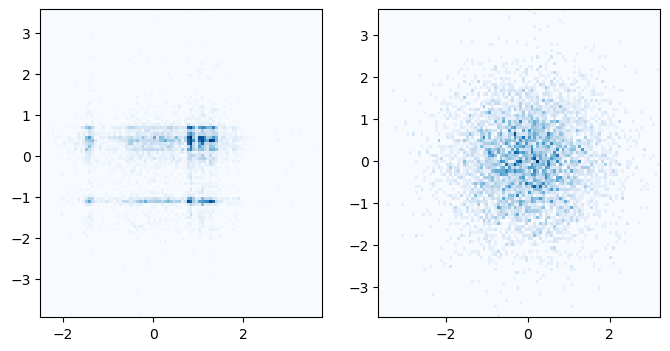

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.644802204778897, -3.5760313855808405, -3.5072605663827847, -3.4384897471847284, -3.3697189279866726, -3.3009481087886163, -3.2321772895905605, -3.163406470392504, -3.094635651194448, -3.025864831996392  …  2.613342342244208, 2.6821131614422637, 2.7508839806403205, 2.8196547998383763, 2.888425619036432, 2.957196438234488, 3.0259672574325447, 3.0947380766306005, 3.1635088958286564, 3.2322797150267135], [-3.720267328654826, -3.64700341696015, -3.5737395052654746, -3.500475593570799, -3.4272116818761234, -3.353947770181448, -3.2806838584867726, -3.207419946792097, -3.1341560350974214, -3.0608921234027457  …  2.94674863556065, 3.020012547255325, 3.093276458950001, 3.166540370644676, 3.2398042823393522, 3.3130681940340274, 3.3863321057287026, 3.4595960174233786, 3.532859929118054, 3.6061238408127303], PyObject <matplotlib.collections.QuadMesh object at 0x7fbca26493a0>)

In [7]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [14]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 15 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = RationalQuadSpline([1.111570716568481 1.111570716568481 … 1.0185016442759476 1.0185016442759476; 1.0478727209204184 1.0478727209204184 … 1.0526033532854298 1.0526033532854298], [0.7952893642911228 0.7952893642911228 … 0.9301422586532254 0.9301422586532254; 0.7652514139745958 0.7652514139745958 … 0.7113600137909963 0.7113600137909963], [1.0 1.0 … 0.12385665205796365 1.0; 1.0 1.6857992124145496 … 0.03986159564280947 1.0]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [3.65949 3.65949 … 4.20073 4.20073; 10.621 10.621 … 10.4379 10.4379]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.0990797 0.0990797 … 0.120149 0.120149; 0.129895 0.129895 … 0.136222 0.136222]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [1.19209e-7 1.19209e-7 … 3.60999e-6 1.19209e-7; 1.19209e-7 2.13599e-5 … 4.6973e-6 1.19209e-7])), negll_history = [2.6663059803809355, 2.738646563913474, 2.5478910617091794, 2.4070271872060096, 2.224994510008065, 2.3552992576478378, 2.21995

In [15]:
yhat = r.result(x)

2×6000 Matrix{Float64}:
 -0.483353  1.02324   -0.733851  -0.147404  …   0.866343  -1.47521   0.229791
 -1.0173    0.887612  -2.05669    1.71974      -1.15112    0.317093  0.671183

In [16]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.0006138039759970821; -0.01572204805851566;;]
std(yhat, dims = 2) = [0.9947682165442894; 0.9671856833942288;;]


2×1 Matrix{Float64}:
 0.9947682165442894
 0.9671856833942288

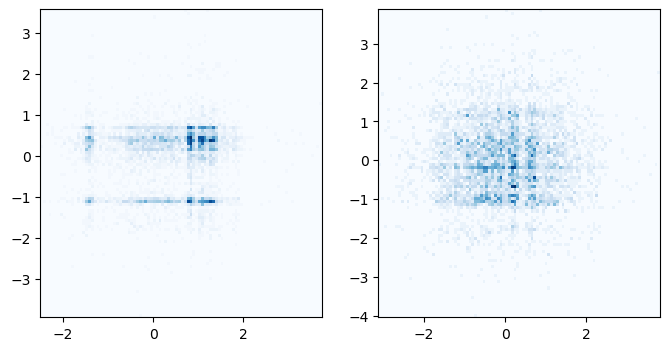

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.1288232569750094, -3.0593265305682165, -2.9898298041614235, -2.920333077754631, -2.850836351347838, -2.781339624941045, -2.711842898534252, -2.6423461721274593, -2.5728494457206663, -2.503352719313874  …  3.1953788460431407, 3.264875572449933, 3.3343722988567266, 3.403869025263519, 3.4733657516703125, 3.542862478077105, 3.6123592044838975, 3.681855930890691, 3.7513526572974834, 3.820849383704276], [-4.045485242013335, -3.9661350015594143, -3.8867847611054938, -3.807434520651573, -3.7280842801976526, -3.648734039743732, -3.5693837992898114, -3.490033558835891, -3.4106833183819703, -3.3313330779280497  …  3.175386639293439, 3.2547368797473597, 3.3340871202012803, 3.413437360655201, 3.4927876011091215, 3.572137841563043, 3.6514880820169635, 3.730838322470884, 3.8101885629248047, 3.8895388033787257], PyObject <matplotlib.collections.QuadMesh object at 0x7fbca6654490>)

In [17]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

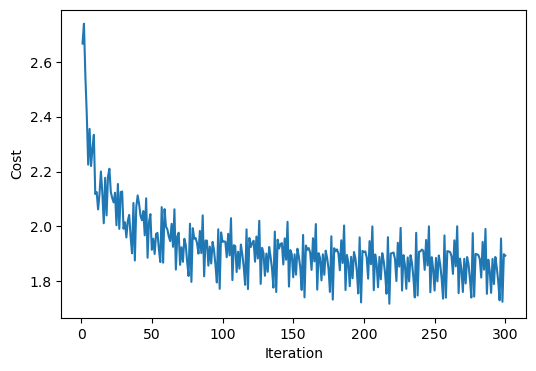

PyObject Text(0.5, 24.0, 'Iteration')

In [18]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [27]:
nparams = 20 # 1180 parameters in total
nsmpls = 6000
ndims = 200
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [28]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

200×6000 Matrix{Float64}:
 -0.996747   -0.688187   -0.393629  …  -0.123262    0.491514  -0.86647
  1.74732     0.0216736  -0.798672     -1.19954    -0.978253   1.40207
 -0.044637    1.12354     0.555235      0.552777    0.163326   0.455705
  0.749967   -2.07784    -0.192704     -0.139843   -0.686999  -1.30854
 -0.303371    0.20297     0.82627      -0.538313   -0.602588   0.973737
  0.507301    0.174556    1.94214   …  -1.39889    -0.227941  -0.0642938
  3.55776    -2.93887     0.81916       3.74876    -0.46363   -3.25277
  0.385395    1.69266     0.880998      1.60288    -0.280192   0.823448
  0.155992   -0.60327    -1.07664      -0.764246   -2.24707   -2.51839
 -1.07723    -1.13614    -1.58053       2.37863     1.84518   -1.36755
  0.702459    1.60141     0.560147  …   0.184397    1.62156    0.578161
 -0.145906    1.19809    -0.693753      0.359744    0.815352  -0.748952
  0.22586    -0.0699501  -1.28064       0.355931    3.72219    0.502126
  ⋮                                 ⋱      

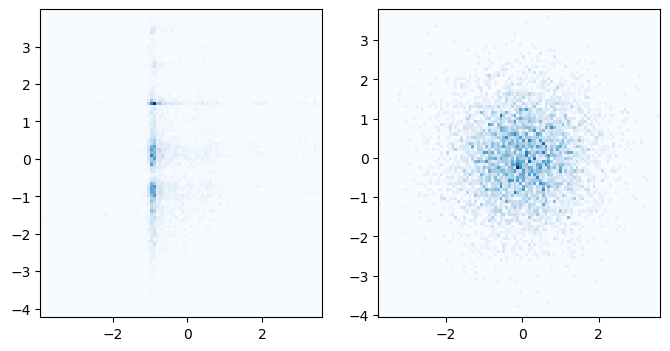

In [29]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [30]:
initial_trafo = 
    RationalQuadSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

In [31]:
yhat = r.result(x);

In [32]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2);

mean(yhat, dims = 2) = [-0.031367095592629284; 0.012131242805905048; 0.03352171383457526; -0.030328651283752336; 0.01533496218806182; 0.06340834191025475; -0.0023147709269885765; -0.00419561405338114; -0.03688768293605808; 0.0010367307992987598; 0.027471219716087375; 0.03981644381047615; -0.0010244055158411581; -0.05332218445244525; 0.03670039577965512; -0.06991060316374999; -0.009936548208077482; -0.08784523036924452; 0.0005109209381185004; -0.04864454190966678; 0.021539288523266167; -0.04930596990287387; -0.016422928377985122; -0.011230363573443869; -0.0858237739609126; 0.015216296174446175; -0.014283388248890016; 0.007942186220193; -0.028703549527044805; -0.029797670784757764; 0.07204754226433127; -0.0587030295688764; 0.02234938837020295; -0.031180915689640747; 0.01588853799354315; 0.023830272191862883; 0.011060418235613087; -0.013741723201494763; -0.030753455322487477; -0.01845352157517254; 0.020137832602764662; 0.03354225823948764; 0.0035559292303311203; 0.04064210435789399; -0.06

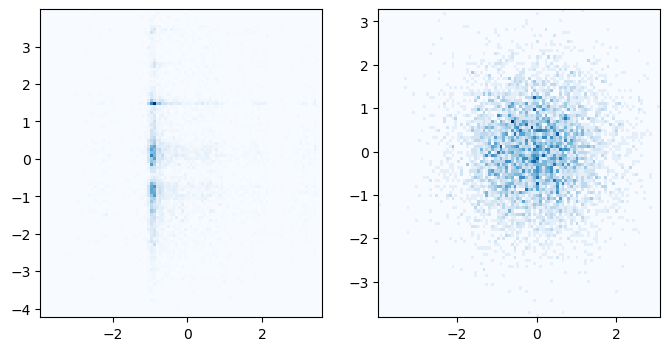

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.9796737925626813, -3.9087765530261422, -3.8378793134896028, -3.7669820739530637, -3.6960848344165247, -3.6251875948799857, -3.554290355343446, -3.483393115806907, -3.412495876270368, -3.3415986367338286  …  2.471975005262384, 2.5428722447989225, 2.613769484335462, 2.6846667238720014, 2.75556396340854, 2.8264612029450795, 2.897358442481619, 2.9682556820181576, 3.039152921554697, 3.1100501610912366], [-3.8222831811168034, -3.7512432268943767, -3.68020327267195, -3.6091633184495233, -3.5381233642270966, -3.46708341000467, -3.396043455782243, -3.3250035015598165, -3.2539635473373902, -3.182923593114963  …  2.6423526531240245, 2.7133926073464507, 2.784432561568878, 2.855472515791304, 2.9265124700137313, 2.9975524242361575, 3.068592378458584, 3.139632332681011, 3.210672286903437, 3.2817122411258643], PyObject <matplotlib.collections.QuadMesh object at 0x7fbcada154f0>)

In [33]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

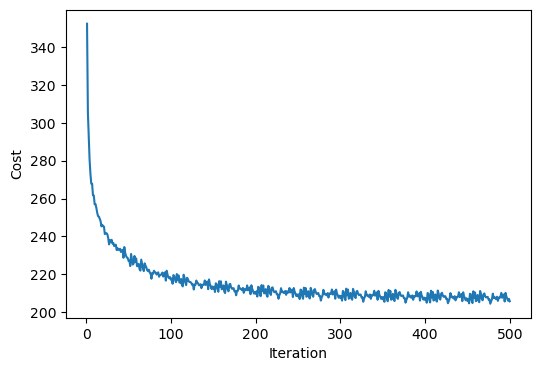

PyObject Text(0.5, 24.0, 'Iteration')

In [34]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")